In [28]:
import pandas as pd
from datetime import datetime, timedelta

# Reading Data

In [29]:
DATA_PATH = "dstest.csv"

In [30]:
df = pd.read_csv(DATA_PATH)
df.describe()

,p2p,cdn,upload,peers_count,peers_match,timestamp,sessionDuration,playbackErrorCount,totalPlaybackErrorCount
count,3.851650e+05,3.851650e+05,3.851650e+05,385165.000000,385165.000000,3.851650e+05,3.851650e+05,385165.000000,385165.000000
mean,8.599490e+06,7.459601e+06,4.303269e+06,5.331324,5.694297,1.562470e+12,2.356197e+06,0.000039,0.000696
std,2.263496e+07,1.155237e+07,1.174622e+07,6.807043,12.818525,6.102775e+06,2.547924e+06,0.008056,0.028361
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.562458e+12,1.200000e+05,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.562465e+12,7.200000e+05,0.000000,0.000000
50%,0.000000e+00,8.196800e+05,0.000000e+00,2.000000,0.000000,1.562471e+12,1.560000e+06,0.000000,0.000000
75%,8.869840e+06,1.110065e+07,3.700024e+06,9.000000,2.000000,1.562476e+12,3.000000e+06,0.000000,0.000000
max,6.065534e+08,3.481350e+08,3.437871e+08,22.000000,240.000000,1.562479e+12,2.148000e+07,3.000000,3.000000


In [31]:
df.sample()

,company,live,mediaEngine,p2p,cdn,upload,peers_count,peers_match,timestamp,sessionDuration,playbackErrorCount,totalPlaybackErrorCount,content
74581,Streamroot TV,VOD,ME1,0.0,8414880.0,0.0,0.0,0,1562478959042,360000.0,0,0,content-08833


# Questions
## Question 1

**Q** : Knowing the goal of the our technology, define a metric to measure our performance. Calculate that performance score for each of the companies in the dataset.

**A** : We want to increase the ratio of data that is downloaded through P2P rather than CDN. Some payloads report no uploaded data, which means we won't be able to compute a performance score for them. From my knowledge, I can only imagine that those correspond to paused livestreams or fully downloaded VODs.



In [50]:
p2p_data_by_company = df.groupby("company")["p2p"].sum() 
cdn_data_by_company = df.groupby("company")["cdn"].sum()

(p2p_data_by_company / (p2p_data_by_company + cdn_data_by_company)).reset_index(name="performance")

,company,performance
0,Flash Infos,0.394056
1,Sports News,0.219914
2,Streamroot TV,0.547288


## Question 2
### 2.1
**Q** : How can we know whether a payload is the first payload of a viewer's session?  
**A** : A payload is the first payload of a session if the sessionDuration is equal to the interval between payloads. Here, it must be equal to 2 minutes (120 000 ms).

### 2.2
**Q** : Add a column `isFirstPayload` to the dataset, that must be `True` if the row represents a payload that was **the first payload** sent by a viewer, and `False` otherwise.

In [33]:
PAYLOAD_INTERVAL_IN_MS = 120000

In [34]:

df["isFirstPayload"] = df["sessionDuration"].apply(lambda x: x <= PAYLOAD_INTERVAL_IN_MS)
df.head()

,company,live,mediaEngine,p2p,cdn,upload,peers_count,peers_match,timestamp,sessionDuration,playbackErrorCount,totalPlaybackErrorCount,content,isFirstPayload
0,Streamroot TV,VOD,ME1,0.0,8507376.0,0.0,0.0,1,1562469807407,120000.0,0,0,content-09235,True
1,Streamroot TV,VOD,ME1,0.0,5778744.0,0.0,0.0,0,1562469927310,240000.0,0,0,content-09235,False
2,Streamroot TV,VOD,ME1,0.0,7692960.0,0.0,0.0,0,1562470047330,360000.0,0,0,content-09235,False
3,Streamroot TV,VOD,ME1,0.0,8229888.0,0.0,0.0,0,1562470167720,480000.0,0,0,content-09235,False
4,Streamroot TV,VOD,ME1,0.0,10387000.0,0.0,0.0,0,1562470287353,600000.0,0,0,content-09235,False


### 2.3
**Q** : Use that column to calculate the **number of distinct viewers** that sent payloads for each company.

In [35]:
df[df.isFirstPayload].groupby("company")["isFirstPayload"].count().reset_index(name="Viewers")

,company,Viewers
0,Flash Infos,805
1,Sports News,115
2,Streamroot TV,19914


## Question 3
### 3.1
**Q** : Let's consider a viewer A who starts a video at T=0, then has a playback error at **T = 2 minutes 30 seconds**, and then another one at **T=6 minutes 20 seconds**. What will be the values of the fields `playbackErrorCount` and `totalPlaybackErrorCount` in the first 5 payloads sent by viewer A?  
**A** :   



| Payload number | SessionDuration | playbackErrorCount | totalPlaybackErrorCount |
|----------------|-----------------|--------------------|-------------------------|
| 1              | 120 000         | 0                  | 0                       |
| 2              | 240 000         | 1                  | 1                       |
| 3              | 360 000         | 0                  | 1                       |
| 4              | 480 000         | 1                  | 2                       |
| 5              | 600 000         | 0                  | 2                       |

##### 3.2
**Q** : Calculate the **number of distinct viewers** that had **at least 1** playback error during their session.  
**A** : To get this number, we must count the number of rows that correspond to the first error of a session e.g. `playbackErrorCount` and `totalPlaybackErrorCount` both equal 1.

In [36]:
f"Number of distinct viewers with at least one playback error : {len(df.query('playbackErrorCount == 1 & totalPlaybackErrorCount == 1').index)}"

'Number of distinct viewers with at least one playback error : 8'

## Question 4

In [37]:
df_tv = df[df.company == "Streamroot TV"]

### 4.1
**Q** : Add a column "readableDate" to the dataset that will be the beginning of the 2 minutes window during which the payload was sent. For example, if a payload was sent at 11:35, the column "readableDate" should be 11:34, if a payload was sent at 10:03, the "readableDate" should be 10:02.


In [38]:
def get_payload_window_start(timestamp: float) -> str:
    """
        Get the beginning of the 2 minute window of a given timestamp (in milliseconds) as a string representation
    """
    dt = datetime.fromtimestamp(timestamp // 1000)
    delta = 0 if dt.minute % 2 == 0 else 1
    dt_window = dt - timedelta(minutes=delta)
    return dt_window.strftime("%H:%M")


In [39]:
df_tv["readableDate"] = df_tv["timestamp"].apply(get_payload_window_start)

<ipython-input-39-4dd10da42244>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tv["readableDate"] = df_tv["timestamp"].apply(get_payload_window_start)


### 4.2
**Q** : Plot the concurrency time series for the content `content-05335`.

In [24]:
concurrency_df = df_tv.groupby(["content", "readableDate"])["live"].count().reset_index(name="concurrentViewers")
df_tv = df_tv.merge(concurrency_df, how="left", on=["content", "readableDate"])
df_tv.head()

,company,live,mediaEngine,p2p,cdn,upload,peers_count,peers_match,timestamp,sessionDuration,playbackErrorCount,totalPlaybackErrorCount,content,isFirstPayload,readableDate,concurrentViewers_x,performance,concurrentViewers_y
0,Streamroot TV,VOD,ME1,0.0,8507376.0,0.0,0.0,1,1562469807407,120000.0,0,0,content-09235,True,05:22,1,0.0,1
1,Streamroot TV,VOD,ME1,0.0,5778744.0,0.0,0.0,0,1562469927310,240000.0,0,0,content-09235,False,05:24,1,0.0,1
2,Streamroot TV,VOD,ME1,0.0,7692960.0,0.0,0.0,0,1562470047330,360000.0,0,0,content-09235,False,05:26,1,0.0,1
3,Streamroot TV,VOD,ME1,0.0,8229888.0,0.0,0.0,0,1562470167720,480000.0,0,0,content-09235,False,05:28,1,0.0,1
4,Streamroot TV,VOD,ME1,0.0,10387000.0,0.0,0.0,0,1562470287353,600000.0,0,0,content-09235,False,05:30,1,0.0,1


In [41]:
TARGET_CONTENT = "content-05335"

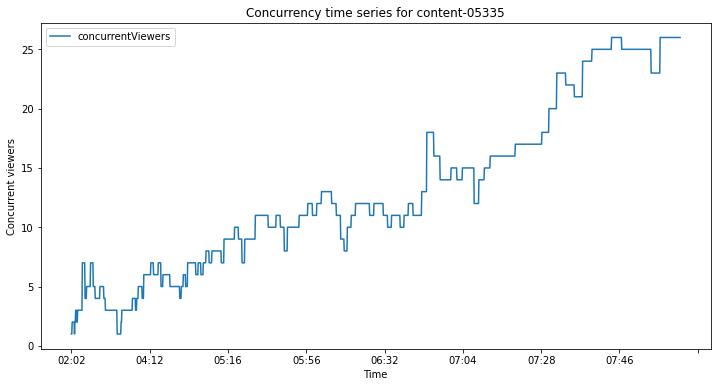

In [42]:
ax = df_tv[df_tv.content == TARGET_CONTENT].sort_values("readableDate").plot(title=f"Concurrency time series for {TARGET_CONTENT}", figsize=(12,6), x="readableDate", y="concurrentViewers")
ax.set_xlabel("Time")
ax.set_ylabel("Concurrent viewers");

### 4.3
**Q** : What is the average performance measured when the concurrency is lower than 10?

In [43]:
df_tv["performance"] = df_tv["p2p"] / (df_tv["p2p"] + df_tv["cdn"])

In [44]:
avg_performance_on_low_concurrency = df_tv[df_tv.concurrentViewers < 10]["performance"].mean()
f"Average performance when concurrency is lower than 10 is {round(avg_performance_on_low_concurrency * 100, 2)}%"

'Average performance when concurrency is lower than 10 is 42.55%'

### 4.4
**Q** : Starting from which concurrency can we say there is a 75% chance that the performance on a content is higher than 80%?


In [45]:
p2p_data_by_content_by_viewers = df_tv.groupby(["concurrentViewers", "content"])["p2p"].sum() 
cdn_data_by_content_by_viewers = df_tv.groupby(["concurrentViewers", "content"])["cdn"].sum()

content_avg = p2p_data_by_content_by_viewers / (p2p_data_by_content_by_viewers + cdn_data_by_content_by_viewers)
p25 = content_avg.groupby("concurrentViewers").quantile(0.25)
p25

concurrentViewers
1     0.000000
2     0.135490
3     0.706755
4     0.254942
5     0.890186
6     0.773076
7     0.894700
8     0.750887
9     0.847967
10    0.910057
11    0.810984
12    0.851612
13    0.844673
14    0.903078
15    0.856071
16    0.085067
17    0.924200
18    0.940226
19    0.897750
20    0.917277
21    0.907211
22    0.989849
23    0.958113
24    0.986709
25    0.880608
26    0.946886
dtype: float64

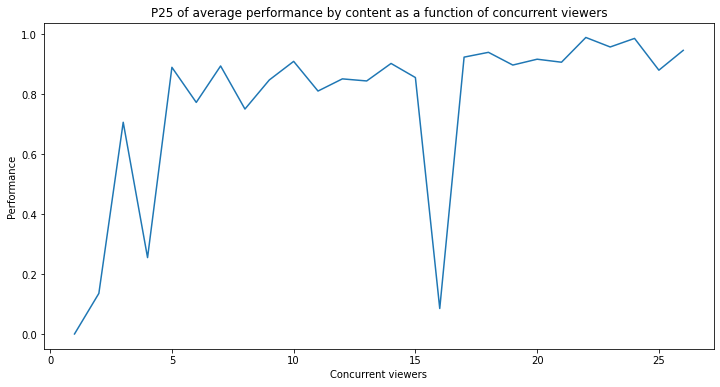

In [46]:
ax = p25.plot(figsize=(12,6), title="P25 of average performance by content as a function of concurrent viewers")
ax.set_xlabel("Concurrent viewers")
ax.set_ylabel("Performance");

**A** : Looking at the P25 of the average performance of contents by concurrentViewers, we can observe that the performance is consistently above 80% starting at 17 concurrent viewers. Performance already looks quite good starting from 13 concurrent viewers but there is an abnormaly low P25 value for 16 concurrent viewers which might require some further analysis.

In [47]:
content_avg[16]

content
content-05333    0.977473
content-05334    0.926401
content-05335    0.975572
content-09757    0.170134
content-10585    0.000000
content-12653    0.972306
content-15940    0.000000
dtype: float64

Both content-10585 and content-15940 seem to have performance issues.

In [48]:
content_avg[:, "content-10585"]

concurrentViewers
4     0.0
8     0.0
16    0.0
dtype: float64

In [49]:
content_avg[:, "content-15940"]

concurrentViewers
1     0.994553
4     0.000000
8     0.000000
12    0.000000
16    0.000000
dtype: float64

Both these contents seem to have issues taking advantage of the P2P system almost no matter how many concurrent viewers there are. Knowing more about the specifics of those contents would be a good starting point into further analysis.